In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import BertTokenizer, BertModel, AutoTokenizer
import matplotlib.pyplot as plt
from torchinfo import summary
import os
import re

In [ ]:
dataset= pd.read_csv("IMDB_Cleaned.csv")
train_data, test_data= train_test_split(dataset, test_size= 0.2, random_state= 42, stratify= dataset['sentiment'])
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
sample_review= train_data['cleaned_review'][0]
tokenized_review= tokenizer(sample_review, return_tensors= 'pt')
input_ids= tokenized_review['input_ids']
input_ids.squeeze(0).shape

torch.Size([333])

In [ ]:
class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts= texts
        self.labels= labels
        self.tokenizer= tokenizer
        self.max_len= max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text, label= self.texts[idx], self.labels[idx]

        # Apply Bert Tokenizer
        encoding= self.tokenizer(
            text,
            max_length= self.max_len,
            padding= 'max_length',
            truncation= True,
            return_tensors= 'pt'
        )

        # Get tensors from encoding dictionary
        input_ids= encoding['input_ids'].squeeze(0)
        attention_mask= encoding['attention_mask'].squeeze(0)
        token_type_ids= encoding['token_type_ids'].squeeze(0)

        label_numerical= 0 if label == 'negative' else 1
        label_tensor= torch.tensor(label_numerical, dtype= torch.long)

        return input_ids, attention_mask, token_type_ids, label_tensor

In [ ]:
# Getting subword lengths distribution
tokenizer= AutoTokenizer.from_pretrained('bert-base-uncased')
subword_lengths= []

batch_size_for_lengths= 1000
for i in range(0, len(train_data), batch_size_for_lengths):
    batch_texts= train_data['cleaned_review'].tolist()[i: i+ batch_size_for_lengths]
    encodings= tokenizer(batch_texts, add_special_tokens= True, padding= False, truncation= False)
    batch_lengths= [len(ids) for ids in encodings['input_ids']]
    subword_lengths.extend(batch_lengths)

pd.Series(subword_lengths).describe(percentiles= [0.7, 0.75, 0.8, 0.85, 0.9])

Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


,0
count,40000.000000
mean,254.273525
std,188.161314
min,11.000000
50%,190.000000
70%,274.000000
75%,309.000000
80%,352.000000
85%,410.000000
90%,497.000000


In [ ]:
max_length= 352
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
train_pt_ds= BERTSentimentDataset(texts= train_data['cleaned_review'].tolist(),
                                labels= train_data['sentiment'].tolist(),
                                tokenizer= tokenizer,
                                max_len= max_length
                                )
test_pt_ds= BERTSentimentDataset(texts= train_data['cleaned_review'].tolist(),
                                 labels= train_data['sentiment'].tolist(),
                                 tokenizer= tokenizer,
                                 max_len= max_length
                                 )
input_ids, attention_mask, token_type_ids, label= train_pt_ds[0]
label, train_data['sentiment'][0]

(tensor(1), 'positive')

In [ ]:
class CustomBertClassifier(nn.Module):
    def __init__(self, model_name, num_classes= 2, dropout_prob= 0.1):
        super().__init__()

        self.bert= BertModel.from_pretrained(model_name)

        # for param in self.bert.parameters():
        #   param.requires_grad= False

        bert_hidden_size= self.bert.config.hidden_size

        self.classifier= nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(bert_hidden_size, num_classes)
        )

    def forward(self, input_ids, attention_mask, token_type_ids):

        outputs= self.bert(
            input_ids= input_ids,
            attention_mask= attention_mask,
            token_type_ids= token_type_ids
        )

        pooled_output= outputs.pooler_output

        logits= self.classifier(pooled_output)

        return logits

In [ ]:
BATCH_SIZE= 16
train_dataloader= DataLoader(dataset= train_pt_ds, batch_size= BATCH_SIZE, shuffle= True)
test_dataloader= DataLoader(dataset= test_pt_ds, batch_size= BATCH_SIZE, shuffle= False)

In [ ]:
MODEL_NAME= 'bert-base-uncased'
NUM_CLASSES= 2
DROPOUT_PROB= 0.1
device= 'cuda' if torch.cuda.is_available() else 'cpu'

bert_1_linear_classifier= CustomBertClassifier(MODEL_NAME, NUM_CLASSES, DROPOUT_PROB)
bert_1_linear_classifier.to(device)
optimizer= torch.optim.Adam(bert_1_linear_classifier.parameters(), lr= 2e-6, eps= 1e-8)
loss_fn= nn.CrossEntropyLoss()

sample_input_ids, sample_att_mask, sample_token_type_ids, sample_label= next(iter(train_dataloader))
summary(bert_1_linear_classifier,
        input_data=[
            sample_input_ids.to(device),
            sample_att_mask.to(device),
            sample_token_type_ids.to(device)
            ],
            dtypes= [torch.long, torch.long, torch.long]
    )

Layer (type:depth-idx)                                       Output Shape              Param #
CustomBertClassifier                                         [16, 2]                   --
├─BertModel: 1-1                                             [16, 768]                 --
│    └─BertEmbeddings: 2-1                                   [16, 352, 768]            --
│    │    └─Embedding: 3-1                                   [16, 352, 768]            23,440,896
│    │    └─Embedding: 3-2                                   [16, 352, 768]            1,536
│    │    └─Embedding: 3-3                                   [1, 352, 768]             393,216
│    │    └─LayerNorm: 3-4                                   [16, 352, 768]            1,536
│    │    └─Dropout: 3-5                                     [16, 352, 768]            --
│    └─BertEncoder: 2-2                                      [16, 352, 768]            --
│    │    └─ModuleList: 3-6                                  --             

In [ ]:
train_losses= []
train_accuracies= []
test_accuracies= []
test_losses= []
epochs= 3
for epoch in range(epochs):
    bert_1_linear_classifier.train()
    running_loss= 0.0
    correct= 0
    total= 0
    for input_ids, attention_mask, token_type_ids, y in train_dataloader:
        input_ids, attention_mask, token_type_ids, y= input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), y.to(device)
        pred= bert_1_linear_classifier(input_ids, attention_mask, token_type_ids)
        loss= loss_fn(pred.squeeze(0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+= loss.item() * input_ids.size(0)
        train_losses.append(running_loss / len(train_dataloader.dataset))

        correct+= (y==pred.squeeze(0).argmax(1)).sum().item()
        total+= y.size(0)

    train_accuracy= correct/total
    train_accuracies.append(train_accuracy)

    correct= 0
    total= 0
    val_loss= 0.0
    bert_1_linear_classifier.eval()
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, y in test_dataloader:

            input_ids, attention_mask, token_type_ids, y= input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), y.to(device)
            pred= bert_1_linear_classifier(input_ids, attention_mask, token_type_ids)
            correct+= (y==pred.squeeze(0).argmax(1)).sum().item()
            total+= y.size(0)
            val_loss+= loss_fn(pred.squeeze(0), y).item() * input_ids.size(0)

        val_accuracy= correct/total
        val_loss/= len(test_dataloader.dataset)
        test_accuracies.append(val_accuracy)
    print(f"Epoch: {epoch + 1} | Train Loss: {loss.item():.4f} | Train Accuracy: {train_accuracy:.2%} | Val_Accuracy: {val_accuracy:.2%} | Val_Loss: {val_loss:.4f}")

Epoch: 1 | Train Loss: 0.0729 | Train Accuracy: 87.58% | Val_Accuracy: 92.92% | Val_Loss: 0.1873
Epoch: 2 | Train Loss: 0.2672 | Train Accuracy: 92.53% | Val_Accuracy: 94.66% | Val_Loss: 0.1474
Epoch: 3 | Train Loss: 0.1505 | Train Accuracy: 93.94% | Val_Accuracy: 96.15% | Val_Loss: 0.1160


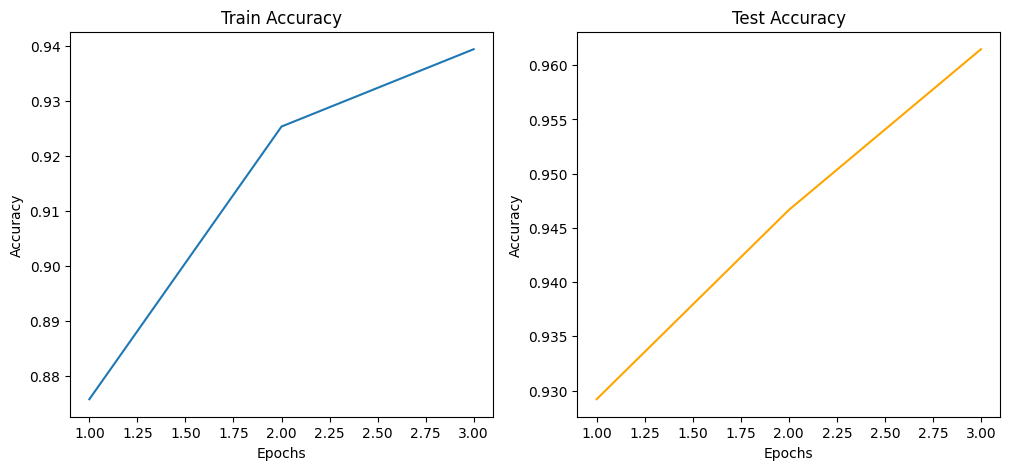

In [ ]:
epochs= range(1, len(train_accuracies) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies)
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, test_accuracies, color= 'orange')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
torch.save(bert_1_linear_classifier, 'bert_1_linear.pth')